In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import os

In [2]:
img_list = glob('C:/Users/pc/Desktop/road/512/512/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2023)

def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list)
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list)
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(1067, 64, 64, 3)
(119, 64, 64, 3)


In [3]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.002,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [4]:
od.fit(
    x_train,
    epochs=300,
    verbose=True
)

17/17 [=] - 1s 63ms/step - loss_ma: -25035.7720


17/17 [=] - 1s 60ms/step - loss_ma: -25195.0651


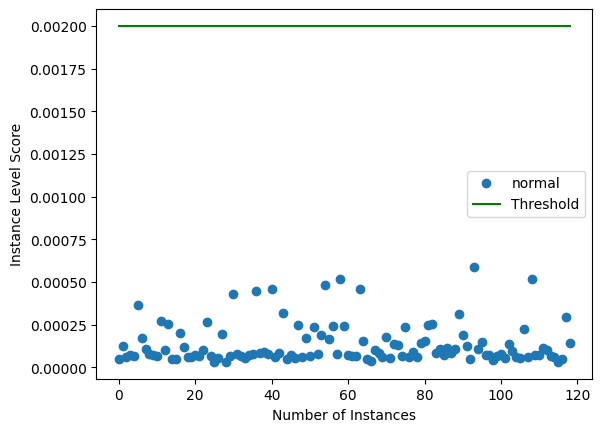

In [5]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

In [6]:
from alibi_detect.od import OutlierVAE
from alibi_detect.saving import save_detector

filepath = 'C:/Users/pc/Desktop/road/new/'
save_detector(od, filepath)

In [7]:
from alibi_detect.saving import load_detector

od_new = load_detector(filepath)

In [8]:
test_img_list = glob('C:/Users/pc/Desktop/road/test/*.png')

x_test = img_to_np(test_img_list[:5])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(5, 64, 64, 3)


In [9]:
test_img_path = glob('C:/Users/pc/Desktop/road/test/wood.png')

test_img = img_to_np(test_img_path)
test_img = test_img.astype(np.float32) / 255.

print(test_img.shape)

(1, 64, 64, 3)


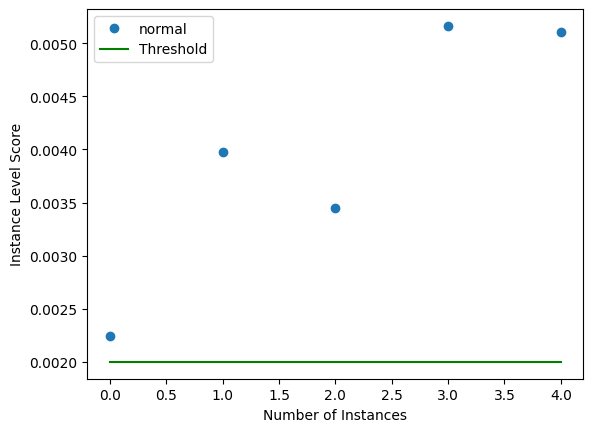

In [10]:
test_preds = od_new.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(test_preds, target, labels, od.threshold)

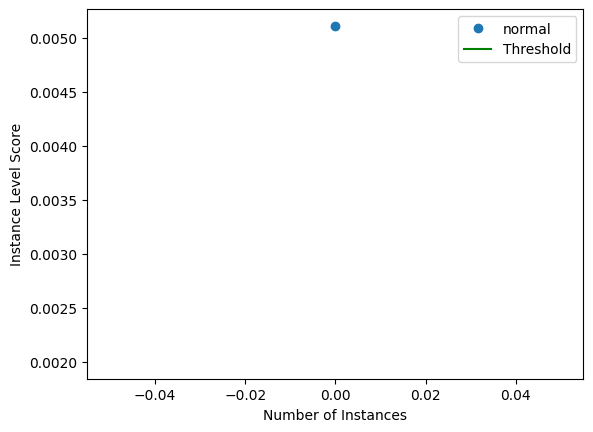

In [13]:
test_pred = od_new.predict(
    test_img,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(test_img.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(test_pred, target, labels, od.threshold)

In [14]:
print(test_pred)

{'data': {'instance_score': array([0.00510941], dtype=float32), 'feature_score': array([[[[1.8859086e-04, 3.9606317e-04, 6.2608236e-04],
         [1.0593943e-03, 1.7257659e-03, 9.1299985e-04],
         [1.4534815e-03, 5.3806405e-04, 4.6646842e-04],
         ...,
         [1.7194505e-04, 1.3738526e-03, 4.6903687e-03],
         [1.0765006e-04, 3.0489900e-04, 3.5041247e-03],
         [1.8848466e-05, 6.6639718e-06, 4.5090943e-05]],

        [[2.3298501e-04, 7.9505025e-07, 4.5884266e-05],
         [1.5803635e-03, 2.1467456e-03, 7.0313457e-04],
         [4.9705297e-04, 1.0247101e-03, 6.9482496e-04],
         ...,
         [1.1170623e-03, 3.0411445e-06, 4.2692288e-03],
         [2.8352503e-04, 4.4796761e-04, 6.6610673e-03],
         [1.0023667e-05, 1.8784482e-03, 4.1503226e-03]],

        [[3.9242066e-05, 1.3110763e-04, 2.9247761e-04],
         [3.4490968e-05, 5.5473984e-06, 1.9033265e-06],
         [3.9764500e-04, 1.1858065e-04, 1.5614581e-06],
         ...,
         [2.9888522e-04, 1.105283

In [24]:
print(bool(test_pred['data']['is_outlier'][0]))

True
